## Pandas (et scikit-learn)

## Données du titanic (challenge Kaggle)

Camille Marini  
Repris d'un notebook d'Alexandre Gramfort donné pour un workshop Python sur ["Predictive Modeling with scikit-learn and pandas"](https://github.com/camillemarini/sklearn_pandas_intro).

Pour cette partie du TP, nous allons utiliser [pandas](http://pandas.pydata.org/), une librairie qui permet de manier facilement des données.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Chargement des données dans un DataFrame pandas 

Nous allons utiliser le jeu de données du challenge Kaggle sur la prédiction de la survie à bord du Titanic:
https://www.kaggle.com/c/titanic-gettingStarted

Pour télécharger les données: 

In [2]:
!wget https://dl.dropboxusercontent.com/u/2140486/data/titanic_train.csv

--2016-11-08 07:55:54--  https://dl.dropboxusercontent.com/u/2140486/data/titanic_train.csv
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 45.58.74.37
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|45.58.74.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/csv]
Saving to: ‘titanic_train.csv.1’

titanic_train.csv.1 100%[===================>]  58,89K  --.-KB/s    in 0,08s   

2016-11-08 07:55:55 (715 KB/s) - ‘titanic_train.csv.1’ saved [60302/60302]



Pour charger le fichier csv dans un DataFrame pandas:

In [3]:
# data = pd.read_csv('https://dl.dropboxusercontent.com/u/2140486/data/titanic_train.csv')
data = pd.read_csv('titanic_train.csv')

Les DataFrames pandas sont affichés dans des tableaux html dans les jupyter notebook. Regardons les 5 premières lignes: 

In [4]:
data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
list(data.columns)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

Les différentes données sont expliquées sur le site du challenge:

https://www.kaggle.com/c/titanic-gettingStarted/data

In [6]:
data.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

Le DataFrame a 891 lignes. Il manque des données pour certains passagers. 

In [7]:
data.shape

(891, 12)

On peut convertir un DataFrame en un numpy array avec:

In [8]:
data.values

array([[1, 0, 3, ..., 7.25, nan, 'S'],
       [2, 1, 1, ..., 71.2833, 'C85', 'C'],
       [3, 1, 3, ..., 7.925, nan, 'S'],
       ..., 
       [889, 0, 3, ..., 23.45, nan, 'S'],
       [890, 1, 1, ..., 30.0, 'C148', 'C'],
       [891, 0, 3, ..., 7.75, nan, 'Q']], dtype=object)

Le problème est qu'on ne peut pas directement donner ce DataFrame comme entrée d'un modèle scikit-learn, car:

* la variable cible (`Survived`) est avec les variables d'entrée  
* certains attributs comme les ids (`PassengerId`) n'ont aucune valeur prédictive.  
* Les données sont hétérogènes: string et des nombres.  
* certaines données sont manquantes (`nan`: "not a number")  

On va utiliser pandas pour préparer ces données.

## Prédire la survie

Le but du challenge est de prévoir si un passager a survécu à partir d'autres attributs connus. Commençons par regarder la colonne `Survived`:

In [9]:
survived_column = data['Survived']
survived_column.dtype

dtype('int64')

`data.Survived` est une instance de la classe `Series` de pandas avec un dtype integer:

In [10]:
type(survived_column)

pandas.core.series.Series

`data` est une instance de la classe `DataFrame` de pandas:

In [11]:
type(data)

pandas.core.frame.DataFrame

Les instances de `Series` correspondent à des données 1D homogènes, alors que les instances de `DataFrame` sont des collections hétérogènres de colonnes de même longueur. 

Le DataFrame original peut être aggrégé en comptant les lignes pour chaque valeur possible de la variable `Survived`:

In [13]:
data.groupby('Survived').count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


In [14]:
data.groupby('Survived')

In [15]:
np.mean(survived_column == 0)

0.61616161616161613

Dans ces données, 62% des passagers ont péri (68% sur l'ensemble des passagers). On peut choisir comme modèle de référence un modèle qui prédirait constamment la non survie du passager. Il aurait une accuracy de 62% (ce qui est plus grand que le hasard).

On peut convertir les instances `Series` de pandas en un 1D numpy arrays en utilisant l'attribut `values`:

In [16]:
target = survived_column.values

In [17]:
type(target)

numpy.ndarray

In [18]:
target.dtype

dtype('int64')

In [19]:
target[:5]

array([0, 1, 1, 1, 0])

## Entraîner un modèle prédictif sur des features numériques


Les estimateurs `sklearn` acceptent des features numériques passées comme un numpy array. On ne peut donc pas passer le DataFrame brut. 

On commence simplement en construisant un modèle qui utilise seulement les features numériques données telles quelles: `data.Fare`, `data.Pclass` et `data.Age`.

In [20]:
numerical_features = data.get(['Fare', 'Pclass', 'Age'])
numerical_features.head(5)

,Fare,Pclass,Age
0,7.2500,3,22.0
1,71.2833,1,38.0
2,7.9250,3,26.0
3,53.1000,1,35.0
4,8.0500,3,35.0


Malheureusement, il manque l'âge de certains passagers:

In [21]:
numerical_features.count()

Fare      891
Pclass    891
Age       714
dtype: int64

On peut utiliser la méthode `fillna` de pandas pour remplacer les `nan` par l'âge médian des passagers:

In [22]:
median_features = numerical_features.dropna().median()
median_features

Fare      15.7417
Pclass     2.0000
Age       28.0000
dtype: float64

In [23]:
imputed_features = numerical_features.fillna(median_features)
imputed_features.count()

Fare      891
Pclass    891
Age       891
dtype: int64

In [24]:
imputed_features.head(5)

,Fare,Pclass,Age
0,7.2500,3,22.0
1,71.2833,1,38.0
2,7.9250,3,26.0
3,53.1000,1,35.0
4,8.0500,3,35.0


Maintenant que le DataFrame est propre, on peut le convertir en un numpy array:

In [25]:
features_array = imputed_features.values
features_array

array([[  7.25  ,   3.    ,  22.    ],
       [ 71.2833,   1.    ,  38.    ],
       [  7.925 ,   3.    ,  26.    ],
       ..., 
       [ 23.45  ,   3.    ,  28.    ],
       [ 30.    ,   1.    ,  26.    ],
       [  7.75  ,   3.    ,  32.    ]])

In [26]:
features_array.dtype

dtype('float64')

Prenons 80% des données pour l'entraînement et gardons 20% pour calculer le score de généralisation:

In [27]:
from sklearn.model_selection import train_test_split

features_train, features_test, target_train, target_test = train_test_split(
    features_array, target, test_size=0.20, random_state=0)

In [28]:
features_train.shape

(712, 3)

In [29]:
features_test.shape

(179, 3)

In [30]:
target_train.shape

(712,)

In [31]:
target_test.shape

(179,)

Commençons avec un modèle simple de sklearn: [sklearn.linear_model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

**Question**:
* Calculer les prédictions du modèle  
* Calculer l'accuracy de notre modèle. Est ce mieux que le modèle de référence qui prédit toujours la non survie?

In [32]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1.)
logreg.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
target_predicted = logreg.predict(features_test)

In [34]:
from sklearn.metrics import accuracy_score

accuracy_score(target_test, target_predicted)

0.73184357541899436

Notre premier modèle a une accuracy de 73%. C'est mieux que notre modèle de référence qui prédit toujours la non survie!

In [35]:
logreg.score(features_test, target_test)

0.73184357541899436

## Evaluation du modèle et interprétation

### Interpréter les poids du modèle linéaire

L'attribut `coef_` d'un modèle linéaire entraîné (tel que `LogisticRegression`) contient les poids de chaque feature:

In [36]:
feature_names = numerical_features.columns
feature_names

Index(['Fare', 'Pclass', 'Age'], dtype='object')

In [37]:
logreg.coef_

array([[ 0.0043996 , -0.80916725, -0.03348064]])

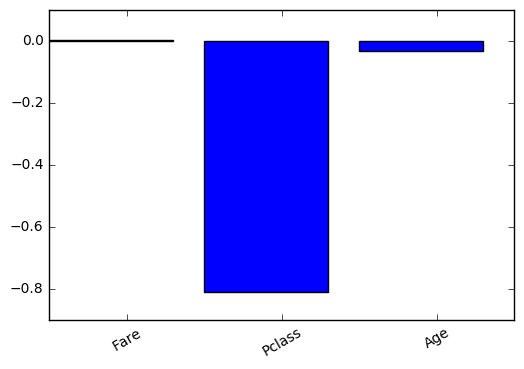

In [38]:
x = np.arange(len(feature_names))
plt.bar(x, logreg.coef_.ravel())
_ = plt.xticks(x + 0.5, feature_names, rotation=30)

Dans notrre modèle, le `Fare` a une influence positive sur la survie, tandis que la `Pclass` et l'`Age` ont une influence négative. 

Les cabines de premières classes étaient plus proches des canots de sauvetage et que les femmes et enfants étaient évacués en priorité. Notre modèle semble capturer ces données historiques! On verra plus tard si le sexe des passagers est une information utilse pour augmenter les performances de notre modèle.

### Méthodes d'évaluation alternatives

On peut utiliser la matrice de confusion pour obtenir les détails des faux positifs et faux négatifs. 

In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(target_test, target_predicted)
print(cm)

[[98 12]
 [36 33]]


Les vraies étiquettes correspondent aux lignes et les prédites aux colonnes.

**Question**:
* faire un plot de la matrice de confusion  

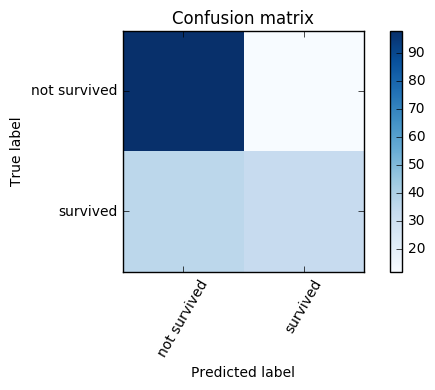

In [40]:
def plot_confusion(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Blues')
    plt.colorbar()

    target_names = ['not survived', 'survived']

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Convenience function to adjust plot parameters for a clear layout.
    plt.tight_layout()
    
plot_confusion(cm)

On peut normaliser le nombre de prédiction en divisant par le nombre total de vrais `survived` et `not survived` pour calculer les taux de faux et vrais postifs pour la survie.

In [38]:
print(cm)
cm.sum(axis=1)

[[98 12]
 [36 33]]


array([110,  69])

In [39]:
print(cm.astype(np.float64) / cm.sum(axis=1))

[[ 0.89090909  0.17391304]
 [ 0.32727273  0.47826087]]


On observe que comme le jeu de données n'est pas balancé (peu de cas de survie par rapport à la non survie), le score d'accuracy n'est pas très informatif: il est assez bon, alors qu'on arrive très mal à prédire les cas de survie. 

On peut utiliser d'autres métriques pour évaluer la performance des modèles pour les jeux de données non balancés: precision, recall et le f1-score.

**Question**:
* Calculer ces métriques en utilisant les fonctions de scikit-learn.

In [41]:
from sklearn.metrics import classification_report

print(classification_report(target_test, target_predicted,
                            target_names=['not survived', 'survived']))

              precision    recall  f1-score   support

not survived       0.73      0.89      0.80       110
    survived       0.73      0.48      0.58        69

 avg / total       0.73      0.73      0.72       179



La régression logistique est un modèle probabiliste: il ne prédit pas qu'un output binaire (survived or not), mais il estime une probabilité que l'on peut obtenir avec la méthode `predict_proba`:

In [42]:
target_predicted_proba = logreg.predict_proba(features_test)
target_predicted_proba[:5]

array([[ 0.75263264,  0.24736736],
       [ 0.75824771,  0.24175229],
       [ 0.58542437,  0.41457563],
       [ 0.25224882,  0.74775118],
       [ 0.75817844,  0.24182156]])

Par défault, la seuil de décision est à 0.5. Si on varie ce seuil de 0 à 1, on peut générer une famille de classifieurs binaires qui correspondent à différents compromis entre les taux de faux positifs et faux négatifs.

On peut résumer les performances de cette famille en plottant la courbe ROC et en calculant l'AUC (Area Under the Curve).

**Question**:
* en utilisant `sklearn.metrics.roc_curve` et `sklearn.metrics.auc`, dessiner cette courbe et afficher la valeur de l'AUC

In [43]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or or recall or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

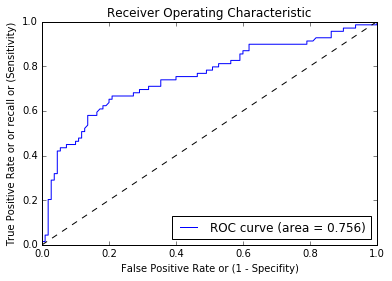

In [43]:
plot_roc_curve(target_test, target_predicted_proba)

Ici, l'AUC vaut 0.756, ce qui est similaire à l'accuracy de notre modèle (0.732).   
L'AUC d'un modèle random vaut 0.5, tandis que l'accuracy est influencé par le fait que le jeu de données n'est pas bien balancé. L'AUC peut être vue comme une façon de calibrer l'accuracy d'un modèle en prenant en compte le fait que le jeu de données n'est pas bien balancé.

### Validation croisée

Il est important de faire de la validation croisée pour évaluer notre modèle. 

**Question**:

- Calculer les scores "cross-validés" pour différentes métriques ('AUC', 'precision', 'recall', 'f1', 'accuracy'...).

In [49]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(logreg, features_array, target, cv=5)
scores

array([ 0.63128492,  0.68715084,  0.70224719,  0.73033708,  0.71751412])

In [50]:
scores.min(), scores.mean(), scores.max()

(0.63128491620111726, 0.69370682962933028, 0.7303370786516854)

In [51]:
scores = cross_val_score(logreg, features_array, target, cv=5,
                         scoring='roc_auc')
scores.min(), scores.mean(), scores.max()

(0.61093544137022393, 0.72123181651091728, 0.78776737967914434)

In [60]:
for k in range(3, 11):
    %time scores = cross_val_score(logreg, features_array, target, cv=k, scoring='roc_auc')
    print(scores.min(), scores.mean(), scores.max())

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 24.7 ms
(0.64818809318377912, 0.72110376122455488, 0.79280510018214922)
CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 23.7 ms
(0.63313110886417256, 0.72158047959354821, 0.78248175182481761)
CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 27.6 ms
(0.61093544137022393, 0.72123181651091728, 0.78776737967914434)
CPU times: user 84 ms, sys: 4 ms, total: 88 ms
Wall time: 85.4 ms
(0.57799389778794819, 0.72203554454698615, 0.80171582803161734)
CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 38.3 ms
(0.57129940583828465, 0.72395098497042454, 0.78990057561486127)
CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 46.6 ms
(0.58931580721267274, 0.71890803212083609, 0.81425070028011204)
CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 56.9 ms
(0.5709663503019845, 0.72066436583261428, 0.83283002588438304)
CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 50 ms
(0.57428571428571429, 0.721

## Entraîner un modèle prédictif sur des features plus complexes

On va maintenant essayer de construire des modèles plus riches en incluant plus de features. 

Les variables catégorielles, telles que `data.Embarked` ou `data.Sex` peuvent être converties comme des booléens, appelés "dummy variables" ou "one-hot-encoded features":

In [61]:
pd.get_dummies(data.Sex, prefix='Sex').head(5)

,Sex_female,Sex_male
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,0.0,1.0


In [44]:
pd.get_dummies(data.Embarked, prefix='Embarked').head(5)

,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


**Question**: 
* Combiner ces nouvelles variables numériques avec les précédentes features dans un pandas DataFrame (appelé `rich_features`) en utilisant `pandas.concat`  

In [45]:
rich_features = pd.concat([data.get(['Fare', 'Pclass', 'Age']),
                           pd.get_dummies(data.Sex, prefix='Sex'),
                           pd.get_dummies(data.Embarked, prefix='Embarked')],
                          axis=1)
rich_features.head(5)

,Fare,Pclass,Age,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,7.2500,3,22.0,0.0,1.0,0.0,0.0,1.0
1,71.2833,1,38.0,1.0,0.0,1.0,0.0,0.0
2,7.9250,3,26.0,1.0,0.0,0.0,0.0,1.0
3,53.1000,1,35.0,1.0,0.0,0.0,0.0,1.0
4,8.0500,3,35.0,0.0,1.0,0.0,0.0,1.0


Par construction, la nouvelle feature `Sex_male` est redondante avec  `Sex_female`. On peut l'enlever:

In [46]:
rich_features_no_male = rich_features.drop('Sex_male', 1)
rich_features_no_male.head(5)

,Fare,Pclass,Age,Sex_female,Embarked_C,Embarked_Q,Embarked_S
0,7.2500,3,22.0,0.0,0.0,0.0,1.0
1,71.2833,1,38.0,1.0,1.0,0.0,0.0
2,7.9250,3,26.0,1.0,0.0,0.0,1.0
3,53.1000,1,35.0,1.0,0.0,0.0,1.0
4,8.0500,3,35.0,0.0,0.0,0.0,1.0


N'oublions pas d'imputer la valeur d'âge médian pour les passagers sans information d'âge:

In [47]:
rich_features_no_male.count()

Fare          891
Pclass        891
Age           714
Sex_female    891
Embarked_C    891
Embarked_Q    891
Embarked_S    891
dtype: int64

In [48]:
rich_features_final = rich_features_no_male.fillna(rich_features_no_male.dropna().median())
rich_features_final.count()

Fare          891
Pclass        891
Age           891
Sex_female    891
Embarked_C    891
Embarked_Q    891
Embarked_S    891
dtype: int64

**Question**:
* Calculer les scores "cross-validés" d'un modèle de régression logistique utilisant ces nouvelles features.

In [50]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression(C=1.)
scores = cross_val_score(logreg, rich_features_final, target, cv=5, scoring='accuracy')
print("Logistic Regression CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    scores.min(), scores.mean(), scores.max()))

Logistic Regression CV scores:
min: 0.770, mean: 0.786, max: 0.810
CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 50.8 ms


**Question**:

* Afficher les poids des features de ce nouveau modèle de régression logistique. 

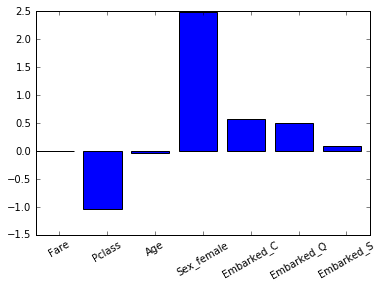

In [51]:
logreg_new = LogisticRegression(C=1).fit(rich_features_final, target)            
                                                                                 
feature_names = rich_features_final.columns.values                               
x = np.arange(len(feature_names))                                                
plt.bar(x, logreg_new.coef_.ravel())                                             
_ = plt.xticks(x + 0.5, feature_names, rotation=30)                              
                                                                                 
# Rich young women like Kate Winslet tend to survive the Titanic better          
# than poor men like Leonardo.  

## Utiliser les pipelines

Quand on a rempli les valeurs manquantes par les valeurs médianes (imputation) avant de calculer les ensembles de train et de test, on utilise des données de test, ce qui est tricher...

Pour éviter cela, on devrait calculer les valeurs médianes seulement sur les données d'éntraînement et imputer ces valeurs à la fois sur les données d'entraînement et de test.

Pour cela, on peut préparer les features comme précédemment mais sans l'imputation, puis on utilise `sklearn.preprocessing.Imputer` pour calculer les valeurs médianes sur l'ensemble d'entraînement et les imputer aux valeurs manquantes sur l'ensemble d'entraînement et de test. On utilise enfin un `sklearn.pipeline.Pipeline` pour mettre tout ça ensemble.

In [124]:
features = pd.concat([data.get(['Fare', 'Age']),
                      pd.get_dummies(data.Sex, prefix='Sex'),
                      pd.get_dummies(data.Pclass, prefix='Pclass'),
                      pd.get_dummies(data.Embarked, prefix='Embarked')],
                     axis=1)
features = features.drop('Sex_male', 1)
features.head(10)

,Fare,Age,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,7.2500,22.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,71.2833,38.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,7.9250,26.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,53.1000,35.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,8.0500,35.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,8.4583,NaN,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6,51.8625,54.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7,21.0750,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8,11.1333,27.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
9,30.0708,14.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [125]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features.values, target, random_state=0)

In [126]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median', missing_values="NaN")

imputer.fit(X_train)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

Les valeurs médianes sont enregistrées dans l'attribut `statistics_`.

In [127]:
imputer.statistics_

array([ 14.5,  29. ,   0. ,   0. ,   0. ,   1. ,   0. ,   0. ,   1. ])

L'imputation se fait en appellant la méthode `transform`:

In [128]:
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

On utilise maintenant un pipeline pour combiner l'imputation et le classifieur: 

In [135]:
from sklearn.pipeline import Pipeline

imputer = Imputer(strategy='median', missing_values="NaN")

classifier = LogisticRegression(C=1.)

pipeline = Pipeline([
    ('imp', imputer),
    ('clf', classifier),
])

scores = cross_val_score(pipeline, features.values, target, cv=5, n_jobs=4,
                         scoring='accuracy', )
print(scores.min(), scores.mean(), scores.max())

(0.7696629213483146, 0.78899374314442905, 0.81564245810055869)


### Crédits

Merci à:
* Alexandre Gramfort pour ce notebook  
* Kaggle pour la mise en place de ce challenge Titanic  
* Ce blog post de Philippe Adjiman dont s'est inspiré A. Gramfort:
http://www.philippeadjiman.com/blog/2013/09/12/a-data-science-exploration-from-the-titanic-in-r/